## Introduction

Human life is about pursuing happiness, which is not only hard to get, but also hard to define. The **World Happiness Report** is a publication of the United Nations Sustainable Development Solutions Network. It contains articles and rankings of national happiness, based on respondent ratings of their own lives, which the report also correlates with various (quality of) life factors. Main purpose of this data analysis is to get better understanding about happiness, which might help us to get closer to it.

## Data Preprocessing

### Load data

In [1]:
from sklearn.preprocessing import MinMaxScaler
import geopandas
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import pycountry
import seaborn as sns

In [2]:
%matplotlib inline
mpl.rcParams['figure.facecolor'] = '.99'
mpl.rcParams['axes.facecolor'] = '.97'
mpl.rcParams['savefig.facecolor']

'auto'

`orig_data` : main dataset, contains world happiness score of 2021

In [3]:
orig_data = pd.read_csv('world-happiness-report-2021.csv')
orig_data = orig_data[['Country name', 'Regional indicator', 'Ladder score', 
                       'Logged GDP per capita', 'Social support', 'Healthy life expectancy', 
                       'Freedom to make life choices', 'Generosity',
                       'Perceptions of corruption']]

# replace space to _ in column names
for col in orig_data.columns :
    if ' ' in col:
        orig_data.rename({col:col.replace(' ', '_')}, inplace=True, axis=1)

        
# rename country names to keep consistency with other datasets and geopandas
convert_list = {'Congo (Brazzaville)':'Congo', 'Czech Republic':'Czechia', 
                'Hong Kong S.A.R. of China':'Hong Kong', 'Ivory Coast':"Côte d'Ivoire", 
                'Palestinian Territories':'Palestine, State of', 'Swaziland':'Eswatini', 
                'Taiwan Province of China':'Taiwan'}

for (before, after) in convert_list.items():
    orig_data['Country_name'].loc[orig_data['Country_name'] == before] = after

/home/theopark/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


`merged_data`: population data added to `orig_data`

* Currently, this dataset hasn't been used in the analysis, but it will be used in later update.

In [4]:
popu_data = pd.read_csv('population_by_country_2020.csv')

# rename columns for convenience and consistency
popu_data.rename(columns = {'Country (or dependency)':'Country_name', 
                            'Population (2020)':'Logged_Population', 
                            'Net Change': 'Net_Change', 
                            'Density (P/Km²)':'Density', 
                            'Land Area (Km²)':'Logged_Land_Area', 
                            'Migrants (net)':'Logged_Migrants', 
                            'Fert. Rate':'Fert_Rate', 
                            'Med. Age':'Med_Age', 
                            'Urban Pop %':'Urban_Pop'}, 
                 inplace=True)

# changing the data type for certain columns
temp = popu_data[['Fert_Rate', 'Med_Age', 'Urban_Pop']].copy()
temp = temp.replace('N.A.', np.NaN)
temp['Urban_Pop'] = temp['Urban_Pop'].str[:-2]
popu_data[['Fert_Rate', 'Med_Age', 'Urban_Pop']] = temp.astype('float64')
popu_data['Urban_Pop'] = popu_data['Urban_Pop']/100

# rename country names
convert_list2 = {'Czech Republic (Czechia)':'Czechia', 
                 'State of Palestine':'Palestine, State of'}

for (before, after) in convert_list2.items():
    popu_data['Country_name'].loc[popu_data['Country_name'] == before] = after

# log scaling for certain data
def log(n):
    if n < 0:
        return -(np.log(-n))
    elif n > 0:
        return np.log(n)
    else:
        return n

for item in ('Logged_Population', 'Logged_Land_Area', 'Logged_Migrants'):
    popu_data.loc[:, item] = popu_data[item].map(lambda x: log(x))

merged_data = orig_data.merge(popu_data, how='left')

`ts_data`: contains time series data of world happiness score

In [5]:
ts_data = pd.read_csv('world-happiness-report.csv')
ts_data = ts_data[['Country name', 'year', 'Life Ladder', 'Log GDP per capita',
                   'Social support', 'Healthy life expectancy at birth', 
                   'Freedom to make life choices', 'Generosity', 
                   'Perceptions of corruption']]

# rename column names for consistency
ts_data.rename(columns = {'Life Ladder':'Ladder_score', 
                          'Log GDP per capita':'Logged_GDP_per_capita', 
                          'Healthy life expectancy at birth':'Healthy_life_expectancy'},
               inplace=True)

for col in ts_data.columns:
    if ' ' in col:
        ts_data.rename({col:col.replace(' ', '_')}, inplace=True, axis=1)

# rename country names for consistency
for before, after in convert_list.items():
    ts_data['Country_name'].loc[ts_data['Country_name'] == before] = after

# add regional indicator to dataset
ts_data = ts_data.merge(orig_data[['Country_name', 'Regional_indicator']], how='left')

# fill missing data in regional indicator
region_add = {'Latin America and Caribbean':['Belize', 'Cuba', 'Guyana', 'Suriname', 
                                             'Trinidad and Tobago'],
              'Middle East and North Africa':['Oman', 'Qatar', 'Syria'], 
              'South Asia':['Bhutan'], 
              'Sub-Saharan Africa':['Angola', 'Central African Republic', 'Congo (Kinshasa)', 
                                    'Djibouti', 'Somalia', 'Somaliland region', 'South Sudan',
                                   'Sudan',]
             } 
              
for region in region_add.keys():
    ts_data['Regional_indicator'].loc[ts_data['Country_name'].isin(region_add[region])] = region

### Frequently used variables

In [6]:
score_and_factors = orig_data.columns.drop(['Country_name', 'Regional_indicator'])

factors = orig_data.columns.drop(['Country_name', 'Regional_indicator', 'Ladder_score'])

regions = orig_data['Regional_indicator'].unique()

### Newly created datasets

`normed_data`: normalized version of `orig_data`, used min-max scaling

In [7]:
pre_normed = orig_data.drop(['Country_name', 'Regional_indicator'], axis=1)
min_max_scaler = MinMaxScaler()
normed_data = pd.DataFrame(min_max_scaler.fit_transform(pre_normed), columns=pre_normed.columns)
normed_data = pd.concat([orig_data[['Country_name', 'Regional_indicator']], normed_data], axis=1)

`kor_compare_data`: contains data of South Korea, World average, Top 10 average and East Asia average

In [8]:
kor_data = orig_data[orig_data['Country_name'] == 'South Korea']

top_10 = orig_data[:10].mean()
top_10.loc['Country_name'] = 'Top 10'

east_asia = orig_data[orig_data['Regional_indicator'] == 'East Asia'].mean()
east_asia.loc['Country_name'] = 'East Asia'

world_average = orig_data.mean()
world_average.loc['Country_name'] = 'World Average'

kor_compare_data = pd.concat([kor_data, 
                              pd.DataFrame(top_10).T, 
                              pd.DataFrame(east_asia).T, 
                              pd.DataFrame(world_average).T]
                            ).drop('Regional_indicator', axis=1)

`kor_compare_ts_data`: contains time series data of South Korea, World average, Top 10 average and East Asia average

In [9]:
kor_ts_data = ts_data[ts_data['Country_name'] == 'South Korea'].drop('Regional_indicator', axis=1).reset_index(drop=True)

top_10_ts_list = orig_data['Country_name'][:10]
top_10_ts = ts_data[ts_data['Country_name'].isin(top_10_ts_list)]
top_10_ts = top_10_ts.groupby('year').mean().reset_index()
top_10_ts.loc[:,'Country_name'] = pd.Series(['Top 10 average']*top_10_ts.shape[0])

east_asia_ts = ts_data[ts_data['Regional_indicator'] == 'East Asia']
east_asia_ts = east_asia_ts.groupby('year').mean().reset_index()
east_asia_ts.loc[:,'Country_name'] = pd.Series(['East Asia average']*east_asia_ts.shape[0])

world_average_ts = ts_data.groupby('year').mean().reset_index()
world_average_ts.loc[:,'Country_name']=pd.Series(['World average']*world_average_ts.shape[0])

kor_compare_ts_data = pd.concat([kor_ts_data, top_10_ts, east_asia_ts, world_average_ts])

`normed_kor_compare_data`: normalized version of `kor_compare_data`

In [10]:
normed_kor_data = normed_data[normed_data['Country_name'] == 'South Korea']

normed_top_10 = normed_data[:10].mean()
normed_top_10.loc['Country_name'] = 'Top 10'

normed_east_asia = normed_data[normed_data['Regional_indicator'] == 'East Asia'].mean()
normed_east_asia.loc['Country_name'] = 'East Asia'

normed_world_average = normed_data.mean()
normed_world_average.loc['Country_name'] = 'World Average'

normed_kor_compare_data = pd.concat([normed_kor_data, 
                                     pd.DataFrame(normed_top_10).T, 
                                     pd.DataFrame(normed_east_asia).T,
                                    pd.DataFrame(normed_world_average).T]
                                    ).drop('Regional_indicator', axis=1)

`rank_data`: contains rankings instead of scores

In [11]:
rank_data = orig_data.copy()
for col in score_and_factors:
    rank_data[col] = rank_data[col].rank(method='min', ascending=False)

`group`: data grouped by regional indicator

In [12]:
group = orig_data.groupby('Regional_indicator').mean()
group = pd.DataFrame(group).reset_index()

`world_data`: contains geographic data, for plotting world map

In [13]:
def alpha3code(column):
    codes=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            codes.append(code)
        except:
            codes.append('None')
    return codes

alpha3 = pd.concat([orig_data['Country_name'], orig_data[score_and_factors], 
                    pd.DataFrame(alpha3code(orig_data['Country_name']), columns=['code'])], axis=1)

code_list = {'Taiwan':'TWN', 'South Korea':'KOR', 'Moldova':'MDA', 'Bolivia':'BOL', 'Russia':'RUS', 
             'Vietnam':'VNM', 'Laos':'LAO', 'Venezuela':'VEN', 'Iran':'IRN', 'Tanzania':'TZA', 
            'North Cyprus':'custom1', 'Kosovo':'custom2'}

for country, code in code_list.items():
    alpha3['code'].loc[alpha3['Country_name'] == country] = code

orig_world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
orig_world = orig_world[orig_world.name != 'Antarctica']

orig_world.rename(columns = {'iso_a3':'code'}, inplace=True)

code_list2 = {'Norway':'NOR', 'France':'FRA', 'N. Cyprus':'custom1', 'Kosovo':'custom2'}

for country, a3code in code_list2.items():
    orig_world['code'].loc[orig_world['name'] == country] = a3code

world_data=pd.merge(orig_world, alpha3, on='code', how='left')

/home/theopark/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


### Custom color, palette and colormaps

In [14]:
main_color = '#FF9001'

diverging_palette = ['#FF9001','#F39A28','#E7A54F','#DCAF76','#D0BA9D',
                     '#B4B4B4','#A4A4A4','#939393','#838383','#737373']

contrast_palette = ['#C4C4C4','#FF4900']

highlight_palette = ['#FF9001','#4B4B4B','#C4C4C4','#9C9C9C']

color_dict = {'Western Europe': '#FF9001', 
              'North America and ANZ': '#FF4200', 
              'Latin America and Caribbean': '#FFB702', 
              'Central and Eastern Europe': '#E7BD53', 
              'East Asia': '#CEC2A4', 
              'Southeast Asia': '#737373', 
              'Commonwealth of Independent States': '#B0B0B0', 
              'Middle East and North Africa': '#9C9C9C', 
              'Sub-Saharan Africa': '#C4C4C4', 
              'South Asia': '#4B4B4B'}

In [15]:
norm = mpl.colors.Normalize(-1,1)

heat_colors = [[norm(-1.0), '#000000'],
          [norm(-0.5), '#4B4B4B'],
          [norm(0), '#C4C4C4'],
          [norm(0.5), '#FF9001'],
          [norm(1.0), '#FF4200']]
heat_cmap = mpl.colors.LinearSegmentedColormap.from_list("", heat_colors)

heat_colors_r = [[norm(-1.0), '#FF4200'], 
                 [norm(-0.5), '#FF9001'], 
                 [norm(0), '#C4C4C4'], 
                 [norm(0.5), '#4B4B4B'], 
                 [norm(1.0), '#000000']]
heat_cmap_r = mpl.colors.LinearSegmentedColormap.from_list("", heat_colors_r)

### Functions

In [16]:
# draw a worldmap plot
def worldmap_plot(key):
    fig, ax = plt.subplots(1, 1, figsize=(19,7))
    world_data.plot(column=key, ax=ax, cmap=heat_cmap, legend=True, 
                  missing_kwds={'edgecolor':'red', 'hatch':'///'})
    ax.yaxis.set_ticks([])
    ax.xaxis.set_ticks([])
    ax.set_title(f'{key}: world map', fontdict={'fontsize':18}, pad=16)


# draw a barplot of top and bottom n countries
def top_bottom_barplot(key, data=orig_data, n=5, ascending=False, 
                       figsize=None, annot_size=9, annot_color=['#FFFFFF', '#FFFFFF'], annot_xpos=[0.05, 0.05]):
    temp = data.sort_values(key, ascending=False)
    data = pd.concat([temp[:n], temp[-n:]])[['Country_name', 'Regional_indicator', key]]
    data_regions = data['Regional_indicator'].reset_index(drop=True)
    
    palette = list(data_regions.map(lambda x: color_dict[x]))
    
    if figsize:
        fig = plt.figure(figsize=figsize)
    
    ax = sns.barplot(x=key, y='Country_name', palette=palette, orient='h', data=data)
    
    for i in range(n):
        ax.annotate(data_regions[i], xy=(annot_xpos[0], i+0.15), size=annot_size, weight='bold', color=annot_color[0])
    
    for i in range(n, n*2):
        ax.annotate(data_regions[i], xy=(annot_xpos[1], i+0.15), size=annot_size, weight='bold', color=annot_color[1])

    ax.set_title(f'{key}: Top & Bottom {n}', fontdict={'fontsize':18}, pad=16)
    ax.set_ylabel('');
    

# draw 2 regplots: one from total data and the other from regional mean data
def pair_regplot(x, xlim, x_label_pos, y_label_pos):
    y, ylim = 'Ladder_score', (2.2, 8.2)
    fig, axes = plt.subplots(1,2, figsize=(13,7))

    ax0 = axes[0]
    sns.scatterplot(x=x, y=y, data=orig_data, color=main_color, alpha=0.7, ax=ax0)
    sns.regplot(x=x, y=y, data=orig_data, color=main_color, ax=ax0, scatter=False)
    ax0.set_xlim(xlim)
    ax0.set_ylim(ylim)
    ax0.spines['right'].set_visible(False)
    ax0.spines['top'].set_visible(False)

    ax1 = axes[1]
    sns.scatterplot(x=x, y=y, data=group, color=main_color, ax=ax1)
    for region in group.Regional_indicator:
        plt.text(x=group[x][group.Regional_indicator==region]+x_label_pos, 
                 y=group[y][group.Regional_indicator==region]+y_label_pos, 
                 s=region,
                 fontdict=dict(alpha=0.8, size=7.5))
    
    sns.regplot(x=x, y=y, data=orig_data, color=main_color, ax=ax1, scatter=False)
    ax1.set_xlim(xlim)
    ax1.set_ylim(ylim)
    ax1.spines['right'].set_visible(False)
    ax1.spines['top'].set_visible(False)
    
    fig.suptitle(f'{x} : {y}', fontsize=15, y=0.95);


# draw scatterplot with total data, highlight specific region
def contrast_scatterplot(region):
    temp = orig_data.copy()
    temp.loc[:, region] = (temp.Regional_indicator == region)
    fig, axes = plt.subplots(2,3, figsize=(13,7))
    fig.tight_layout(pad=3)
    for idx, col in enumerate(factors):
        ax = axes[idx//3][idx%3]
        sns.scatterplot(x=col, y='Ladder_score', hue=region, ax=ax, palette=contrast_palette, alpha=0.6, legend=False, data=temp)
        ax.spines['right'].set_visible(False)
        ax.spines['top'].set_visible(False)
    fig.suptitle(f'Region : {region}', fontsize=15, y=1);


# draw radar chart of a given country or region
def radar_chart(region, key, n_yticks=4, y_inf=0, y_sup=1):
    dic = {'c':'Country_name', 'r':'Regional_indicator'}
    data = normed_data[normed_data[dic[key]] == region]
    score = orig_data[orig_data[dic[key]] == region]['Ladder_score'].mean()
    
    fig = plt.figure(figsize=(5,5))
    ax = plt.subplot(polar='True')
        
    values = data[factors].mean().values.tolist()
    values += [values[0]]

    angles = [i / 3.0 * np.pi for i in range(6)]
    angles += [angles[0]]

    plt.polar(angles, values, color=main_color, marker='.')
    plt.fill(angles, values, color=main_color, alpha=0.3)

    plt.xticks(angles[:-1], factors, size=8)
    ax.set_rlabel_position(0)
    plt.yticks(np.linspace(y_inf, y_sup, num=n_yticks, endpoint=False), color='#4B4B4B', size=0)
    plt.ylim(y_inf,y_sup)
    
    ax.set_title(f'{region}: Happiness Score {score:.2f}', fontdict={'fontsize':18}, pad=16);


# draws time series heatmap of a given region
def regional_heatmap(region):
    ts_regional = ts_data[ts_data['Regional_indicator'] == region]
    length = ts_regional['Country_name'].nunique()
    pivot = ts_regional.pivot('Country_name', 'year', 'Ladder_score')
    
    fig = plt.figure(figsize=(11,2+length/3))
    ax = sns.heatmap(pivot, vmin=2.2, vmax=8.2, cmap=heat_cmap, annot=True, fmt='.2g', linewidth=.5, square=True)
    ax.set_title(f'Region: {region}', fontdict={'fontsize':18}, pad=16)
    ax.set_ylabel('');
    

# draw heatmap of a region and its neighborhood
def neighborhood_heatmap(region, key, n=3, rank=True):
    data = rank_data.sort_values(key, ascending=True).reset_index(drop=True)
    target_loc = data.index[data['Country_name'] == region][0]
    neighborhood = data.iloc[target_loc-n:target_loc+n+1,:].set_index('Country_name')

    fig = plt.figure(figsize=(7,5))
    ax = sns.heatmap(neighborhood[score_and_factors], vmin=0, vmax=150, cmap=heat_cmap_r, annot=True, 
                     annot_kws={'size':11}, fmt='g', linewidth=.5, square=True)
    if rank:
        for t in ax.texts: 
            t.set_text('#' + t.get_text())
        
    ax.set_title(f'Similar to {region}: by {key}', fontdict={'fontsize':18}, pad=17)
    ax.text(7.0, -0.05, '(unit: ranking)', fontsize=9, ha="right", color='#4B4B4B')
    ax.set_ylabel('');
    

# draw a barplot with present data, lineplot with historical data
def bar_and_line(data_1, data_2, key):
    fig, axes = plt.subplots(1,2, figsize=(11,5))
    fig.tight_layout(pad=3)
    
    ax0 = axes[0]
    sns.barplot(x='Country_name', y=key, palette=highlight_palette, ax=ax0, data=data_1)
    ax0.set_title(f'2021 {key}', fontdict={'fontsize':11}, pad=9);
    
    ax1 = axes[1]
    sns.lineplot(x='year', y=key, hue='Country_name', style='Country_name', palette=highlight_palette, 
                           linewidth=3.5, ax=ax1, data=data_2)
    ax1.set_title(f'{key} history', fontdict={'fontsize':11}, pad=9)
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    fig.suptitle(f'{key} : Present and the Past', fontsize=15, y=1.05);

## Exploratory Data Analysis

### A quick glance: how happiness is distributed

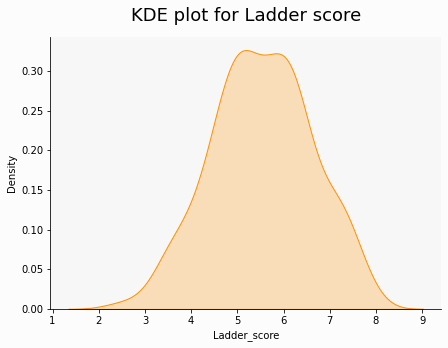

In [17]:
fig = plt.figure(figsize=(7, 5))
ax = sns.kdeplot(x='Ladder_score', color='#FF9001', fill=True, data=orig_data)
ax.set_title('KDE plot for Ladder score', fontdict={'fontsize':18}, pad=16)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

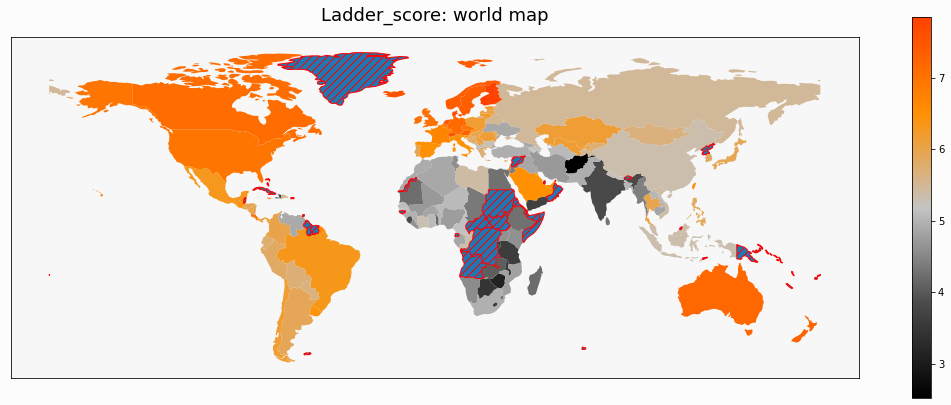

In [18]:
worldmap_plot('Ladder_score')

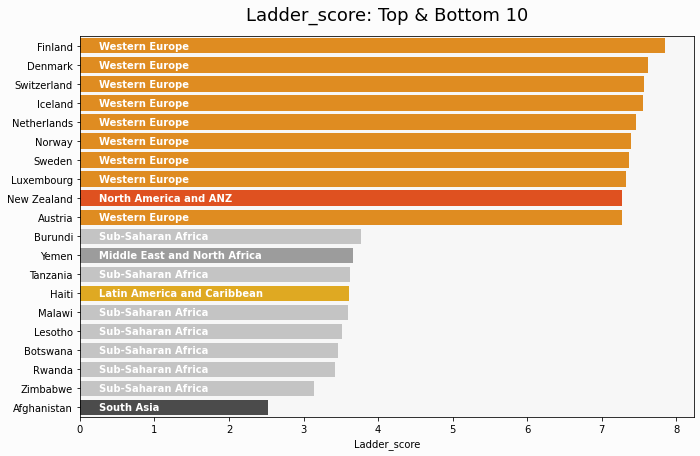

In [19]:
top_bottom_barplot('Ladder_score', n=10, figsize=(11,7), annot_size=10, annot_xpos=[0.25, 0.25])

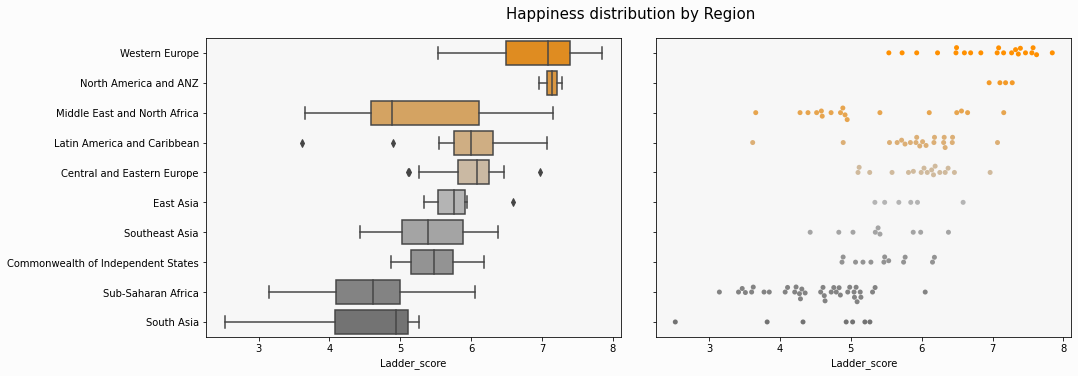

In [20]:
fig, axes = plt.subplots(1,2, sharey=True, figsize=(13,5))
fig.tight_layout(pad=2)

ax0 = axes[0] 
sns.boxplot(x='Ladder_score', y='Regional_indicator', palette=diverging_palette, ax=ax0, data=orig_data)
ax0.set_ylabel('')

ax1 = axes[1]
sns.swarmplot(x='Ladder_score', y='Regional_indicator', palette=diverging_palette, ax=ax1, data=orig_data)
ax1.set_ylabel('')

fig.suptitle('Happiness distribution by Region', fontsize=15, y=1.02);

As you can see, happiness around the world is extremely unbalanced. Most of the happily living countries are located in Western Europe, North America and ANZ(Austrialia and New Zealand), while most of the unhappy countries are in Africa.

### Happiness historic data

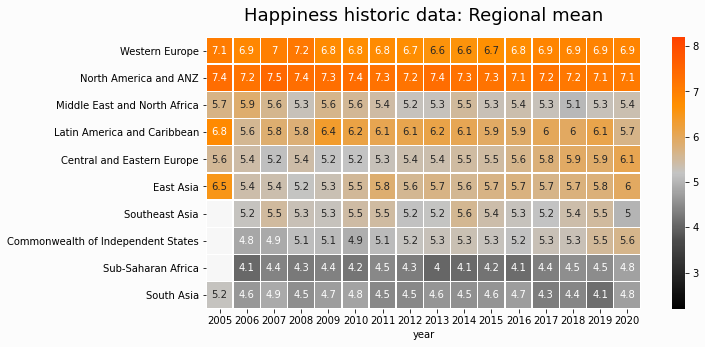

In [21]:
ts_region = pd.DataFrame()
for region in regions:
    ts_region.loc[:,region] = ts_data[ts_data['Regional_indicator'] == region].groupby('year').mean()['Ladder_score']

fig = plt.figure(figsize=(11,5))
ax = sns.heatmap(ts_region.T, vmin=2.2, vmax=8.2, cmap=heat_cmap, annot=True, fmt='.2g', linewidth=.5, square=True)
ax.set_title(f'Happiness historic data: Regional mean', fontdict={'fontsize':18}, pad=16)
ax.set_ylabel('');

We've got data from 2005 to 2020. There are some ups and downs for most of the region. In general, gap between regions didn't get closed much. Interesting thing is, regions that scored high happiness score didn't changed much, while regions with low score seems more volatile.

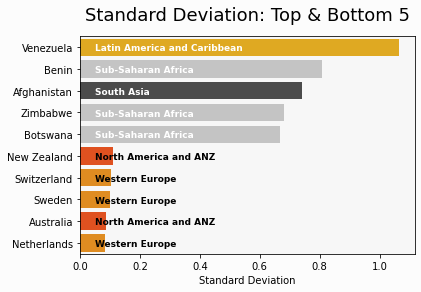

In [22]:
describe = ts_data[['Country_name', 'Regional_indicator', 'Ladder_score']].groupby('Country_name').describe()['Ladder_score']
var_data = describe[describe['count'] >= 10]['std'].reset_index(drop=False).merge(
    ts_data[['Country_name', 'Regional_indicator']].drop_duplicates(), how='left')
var_data.rename({'std':'Standard Deviation'}, axis=1, inplace=True)

top_bottom_barplot('Standard Deviation', data=var_data, n=5, annot_color=['#FFFFFF','#000000'], annot_xpos=[0.05, 0.05])

Those are the countries that have highest and loweset variance in ladder score.

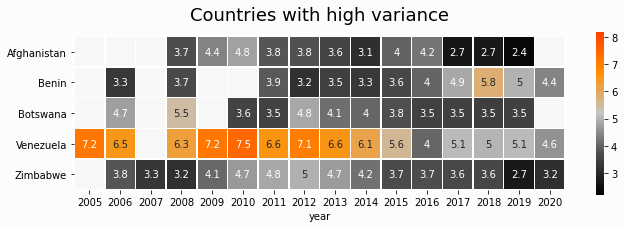

In [23]:
var_idx = var_data.sort_values('Standard Deviation', ascending=False).reset_index(drop=True)

var_top = var_idx.loc[:4,'Country_name']
ts_var_top = ts_data[ts_data['Country_name'].isin(var_top)].drop('Regional_indicator', axis=1)
pivot_var_top = ts_var_top.pivot('Country_name', 'year', 'Ladder_score')

fig = plt.figure(figsize=(11,3))
ax = sns.heatmap(data=pivot_var_top, vmin=2.2, vmax=8.2, cmap=heat_cmap, annot=True, 
                      fmt='.2g', linewidth=.5, square=True)
ax.set_title('Countries with high variance', fontdict={'fontsize':18}, pad=16)
ax.set_ylabel('');

Most prominent thing in this data is fall of Venezuela. A decade ago, they were one of the happiest country in the world, but the score had plummeted recently. Venezuela's been on an economic crisis since 2014, which was caused by drop of oil price. Zimbabwe's been through one of the deadliest inflation in world history, and Afghanistan has been on a war since 2001 and it has not ended yet.
Benin is the only country in this group that showed positive move.

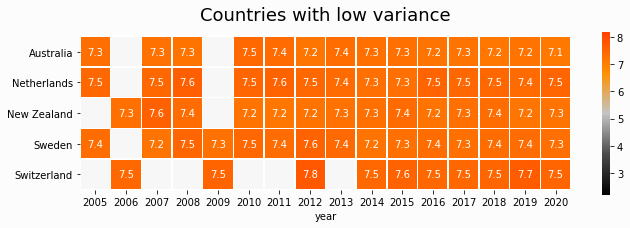

In [24]:
var_bottom = var_idx.loc[122:,'Country_name']
ts_var_bottom = ts_data[ts_data['Country_name'].isin(var_bottom)]
pivot_var_bottom = ts_var_bottom.pivot('Country_name', 'year', 'Ladder_score')

fig = plt.figure(figsize=(11,3))
ax = sns.heatmap(data=pivot_var_bottom, vmin=2.2, vmax=8.2, cmap=heat_cmap, annot=True, 
                      fmt='.2g', linewidth=.5, square=True)
ax.set_title('Countries with low variance', fontdict={'fontsize':18}, pad=16)
ax.set_ylabel('');

Those 5 countries are well developed countries. Their happiness scores are stable maybe because they got stable socioeconomic environment, unlike Venezuela, Zimbabwe or Afghanistan.

### Happiness historic data by region

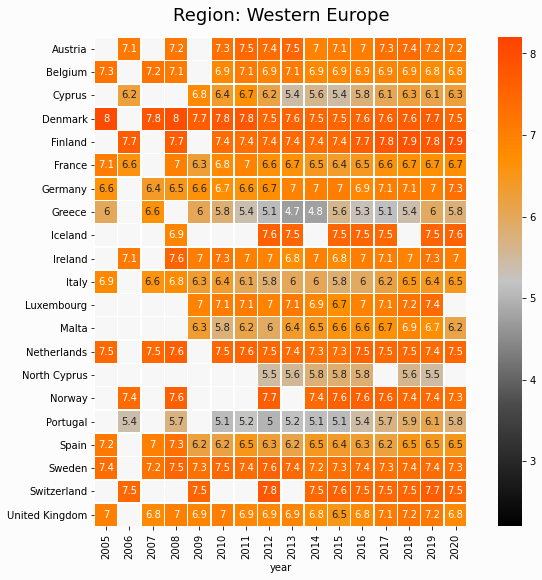

In [25]:
regional_heatmap('Western Europe')

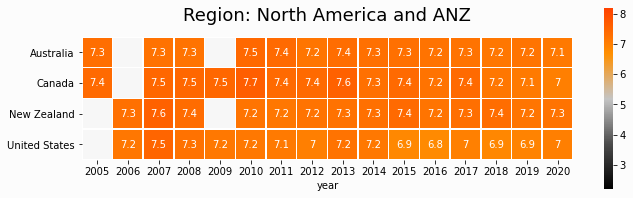

In [26]:
regional_heatmap('North America and ANZ')

Most of the countries in Western Europe, North America and ANZ scored fairly high. They also seems quite stable except Greece, which had a government debt crisis about a decade ago. 

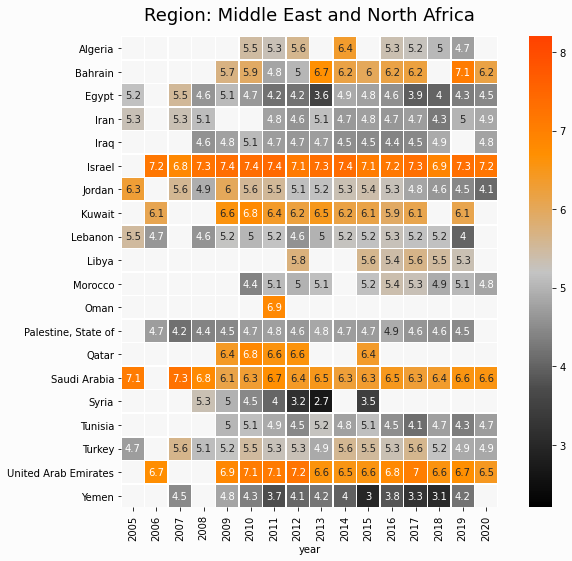

In [27]:
regional_heatmap('Middle East and North Africa')

Happiness in this region are diverse. Most of the high scored countries are oil exporting countries. Some of the countries might got affected by frequent wars.

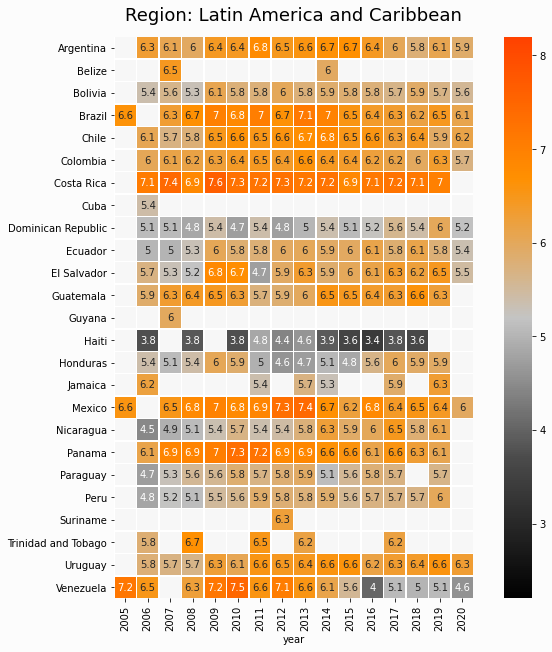

In [28]:
regional_heatmap('Latin America and Caribbean')

In general, score seems improving for majority of countries in Latin America (and we already talked about Venezuela).

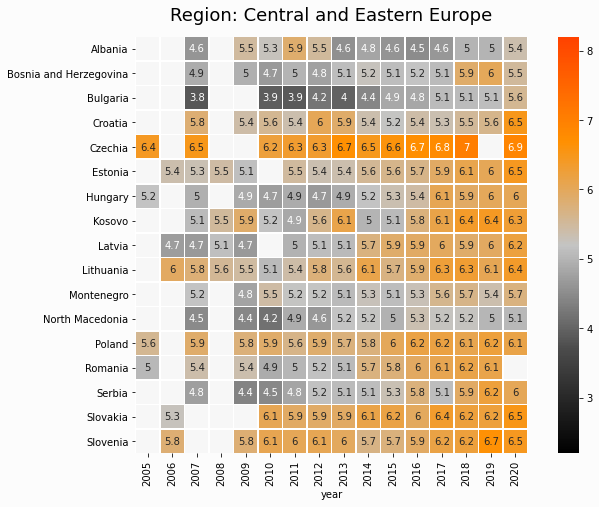

In [29]:
regional_heatmap('Central and Eastern Europe')

Central and Eastern Europe have lower score compared to Western part of the continent, but there's been an improvement lately.

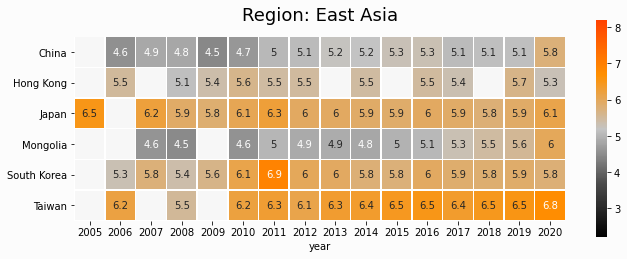

In [30]:
regional_heatmap('East Asia')

East Asia seems quite stable. Some of the countries are rising. We'll talk more about South Korea later.

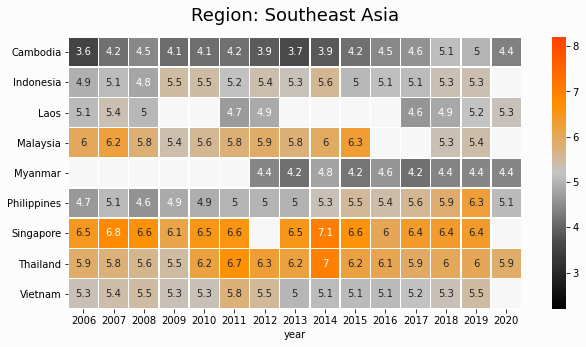

In [31]:
regional_heatmap('Southeast Asia')

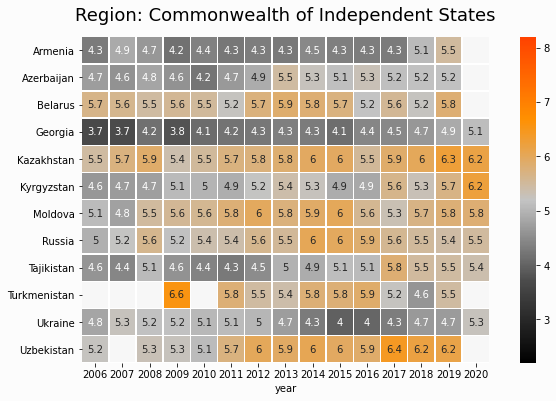

In [32]:
regional_heatmap('Commonwealth of Independent States')

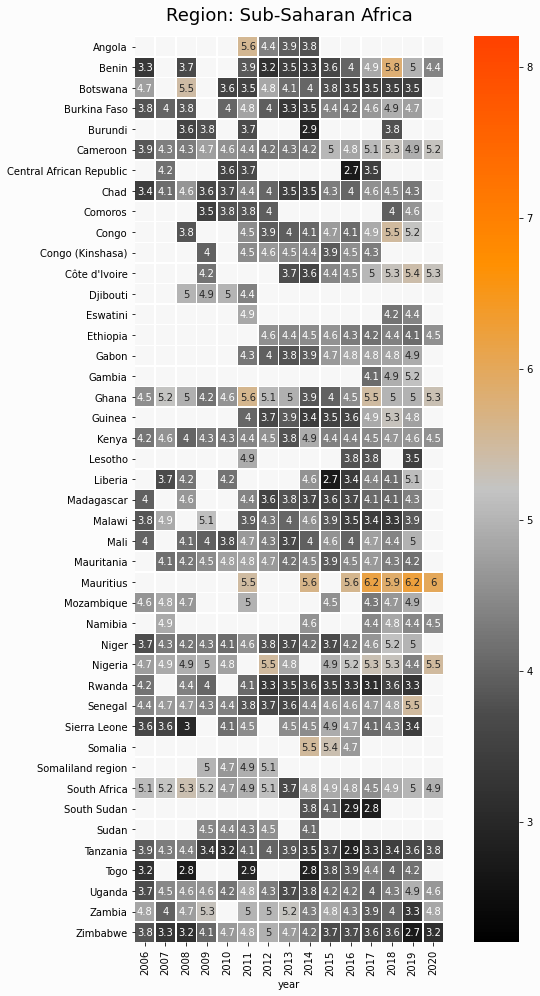

In [33]:
regional_heatmap('Sub-Saharan Africa')

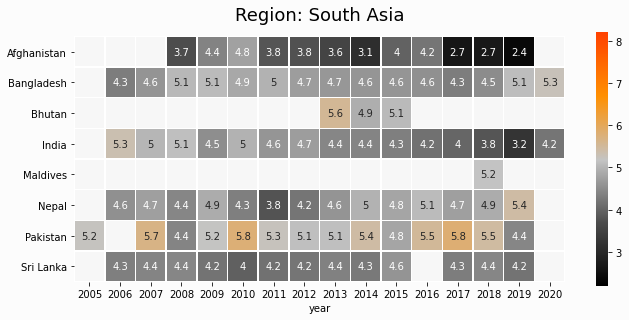

In [34]:
regional_heatmap('South Asia')

Sub-Saharan Africa and South Asia are the regions that have many unsolved social and economical issues. Most of the countries have low and unstable happiness level. Mauritius is the only country that had ever scored over 6.

### Factors correlation analysis: What makes people happy?

In World Happiness Report, there are 6 factors: 

- Logged GDP per capita

- Social support

- Healthy life expectancy

- Freedom to make life choices

- Generosity 

- Perceptions of corruption

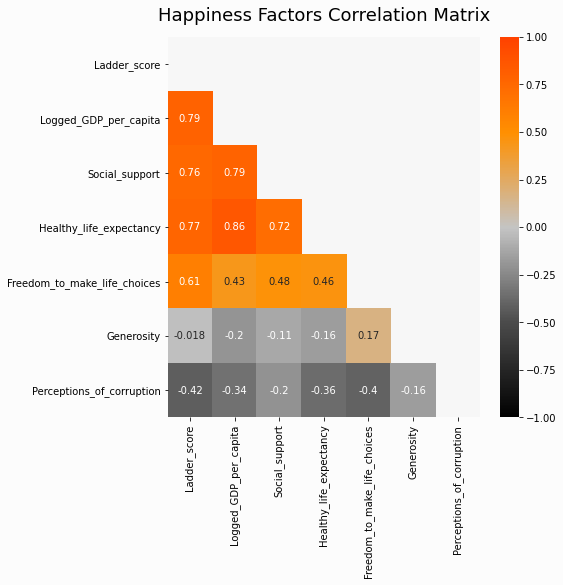

In [35]:
fig = plt.figure(figsize=(7,7))
mask = np.triu(np.ones_like(orig_data.corr(), dtype=np.bool))
ax = sns.heatmap(orig_data.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap=heat_cmap)
ax.set_title('Happiness Factors Correlation Matrix', fontdict={'fontsize':18}, pad=16);

It turns out that income, social support, life expectancy and freedom showed strong positive correlation to happiness score, while perceptions of corruption showed negative correlation to happiness. At this point, it's hard to say that generosity has something to do with happiness.

#### Logged GDP per capita

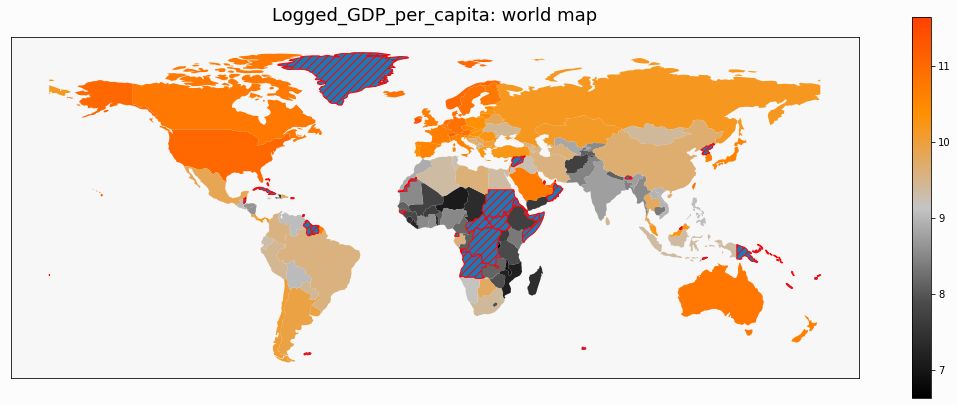

In [36]:
x = 'Logged_GDP_per_capita'
worldmap_plot(x)

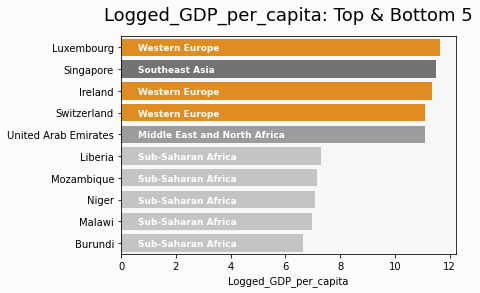

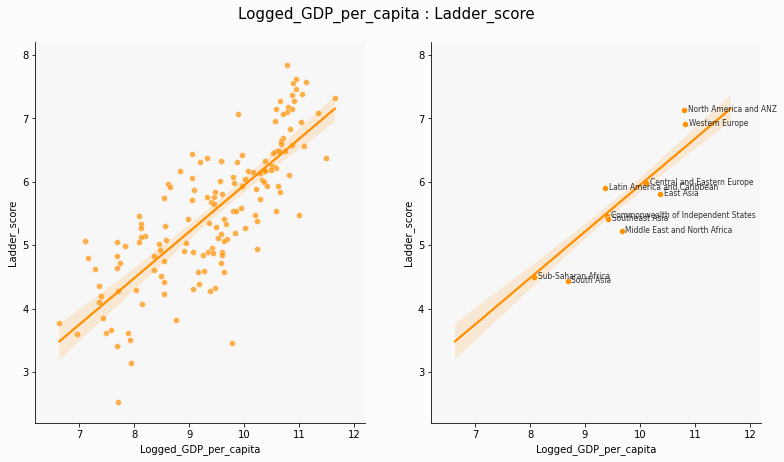

In [37]:
top_bottom_barplot(x, annot_xpos=[0.6, 0.6])
pair_regplot(x, (6.2,12.2), 0.07, -0.03)

#### Social Support

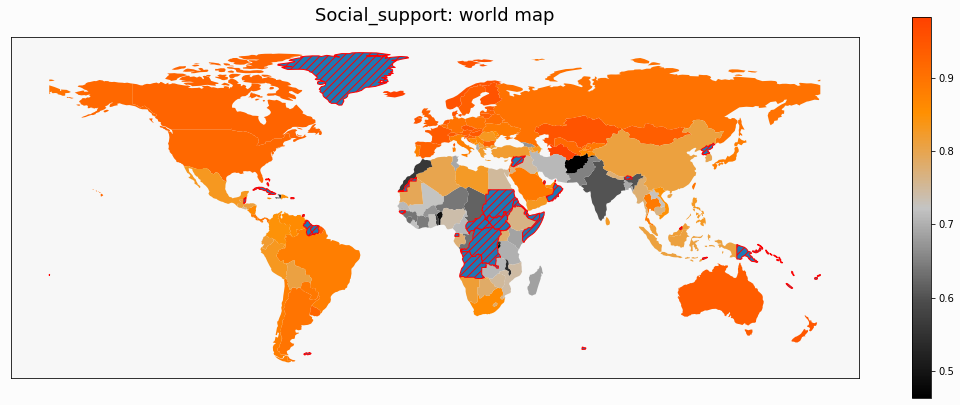

In [38]:
x = 'Social_support'
worldmap_plot(x)

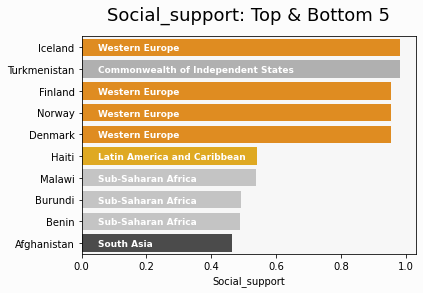

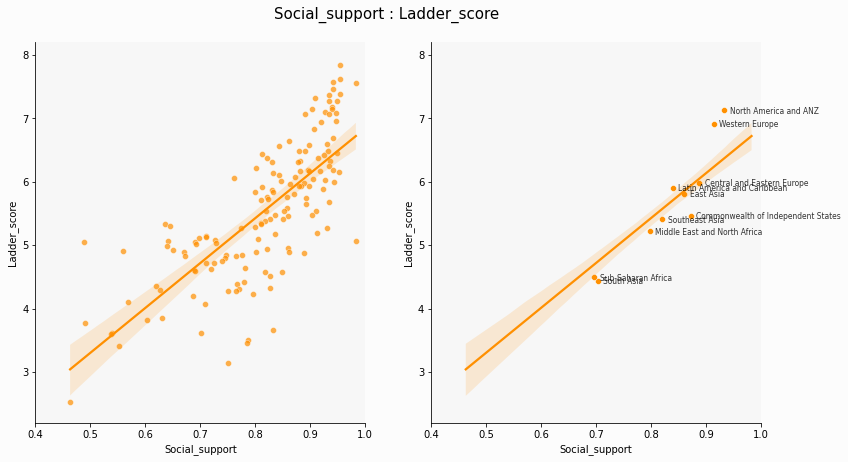

In [39]:
top_bottom_barplot(x)
pair_regplot(x, (0.4,1), 0.01, -0.05)

#### Healthy life expectancy

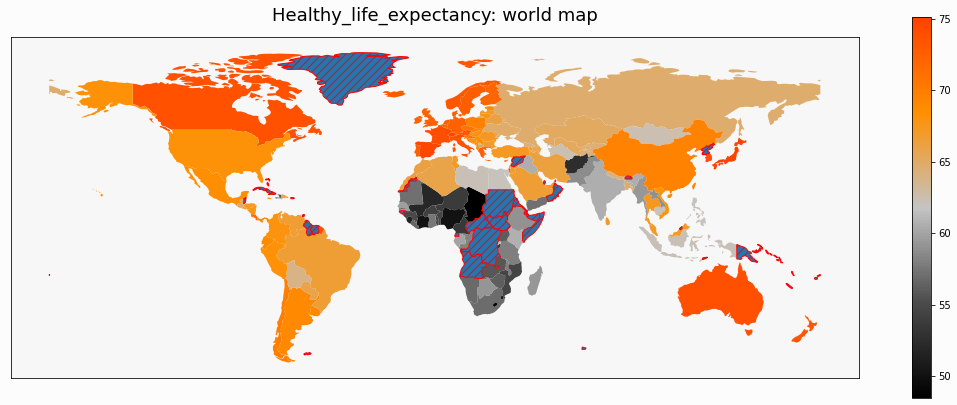

In [40]:
x = 'Healthy_life_expectancy'
worldmap_plot(x)

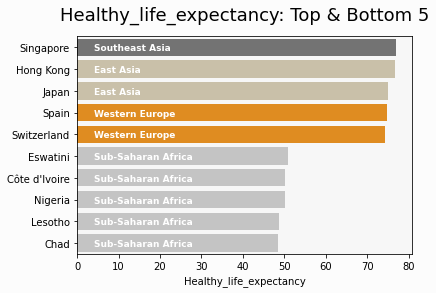

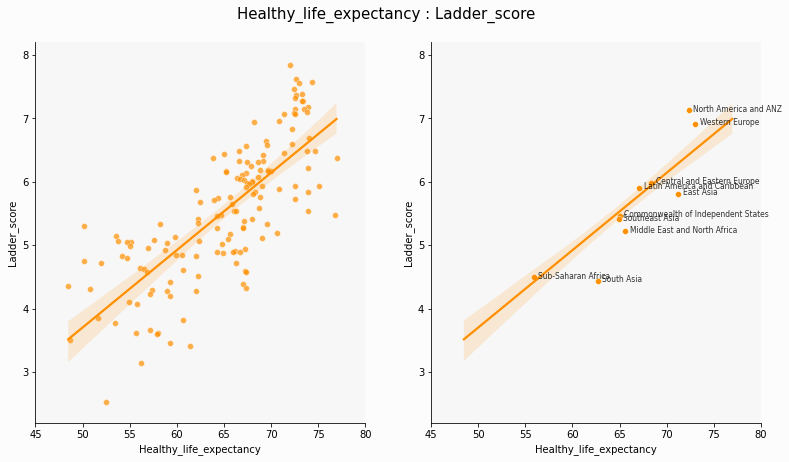

In [41]:
top_bottom_barplot(x, annot_xpos=[4,4])
pair_regplot(x, (45,80), 0.5, -0.02)

#### Freedom to make life choices

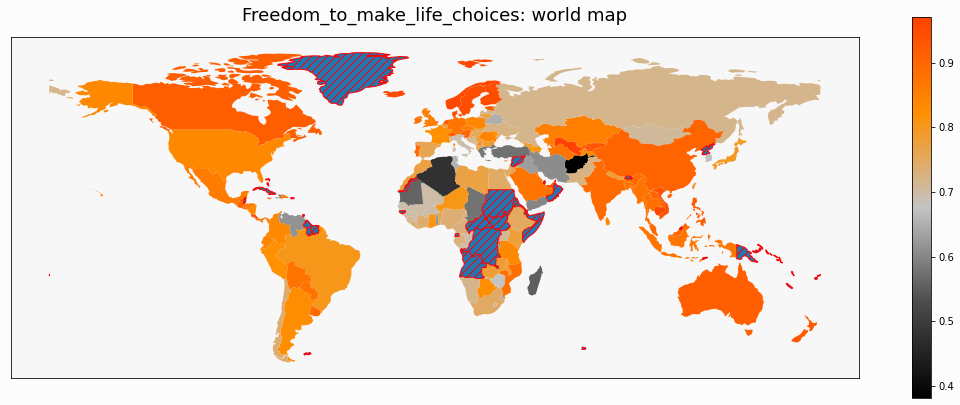

In [42]:
x = 'Freedom_to_make_life_choices'
worldmap_plot(x)

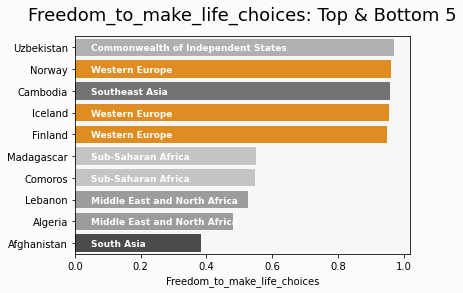

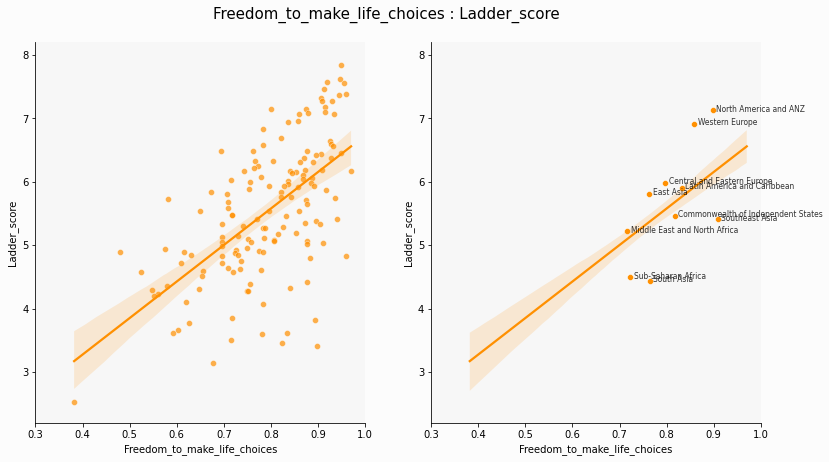

In [43]:
top_bottom_barplot(x)
pair_regplot(x, (0.3,1), 0.007, -0.02)

#### Generosity

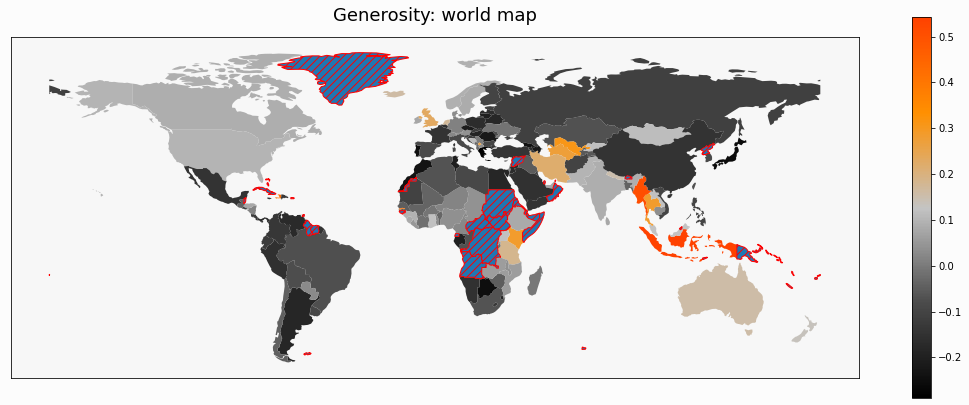

In [44]:
x = 'Generosity'
worldmap_plot(x)

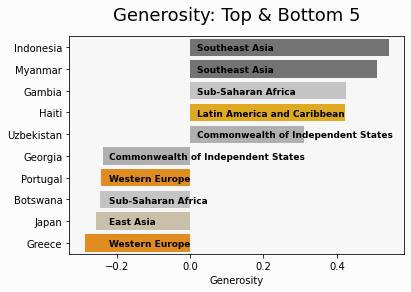

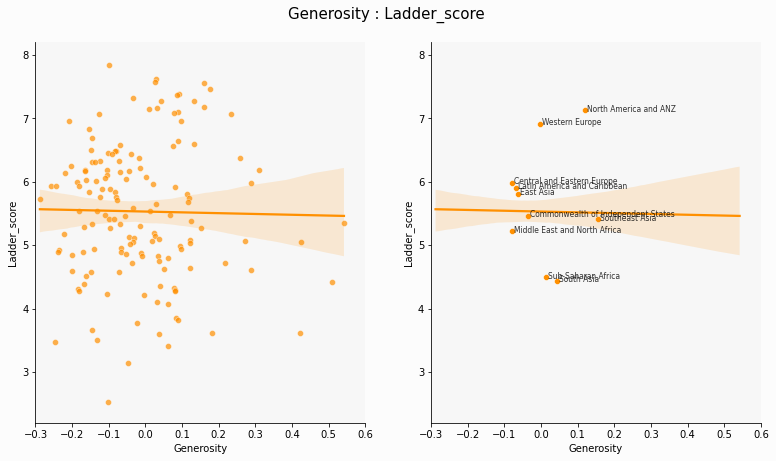

In [45]:
top_bottom_barplot(x, annot_color=['#000000', '#000000'], annot_xpos=[0.02, -0.22])
pair_regplot(x, (-0.3,0.6), 0.005, -0.02)

Unlike other factors above, it's hard to find correlation between generosity and happiness.

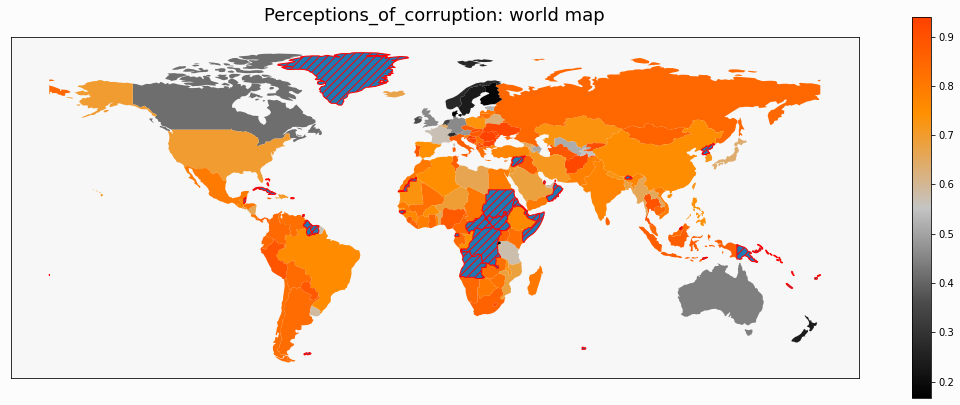

In [46]:
x = 'Perceptions_of_corruption'
worldmap_plot(x)

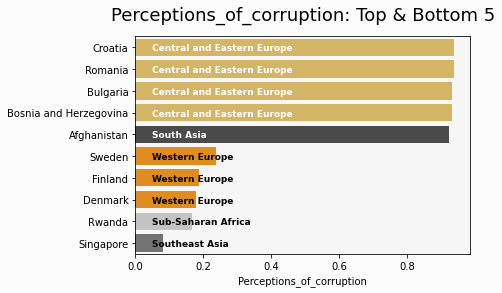

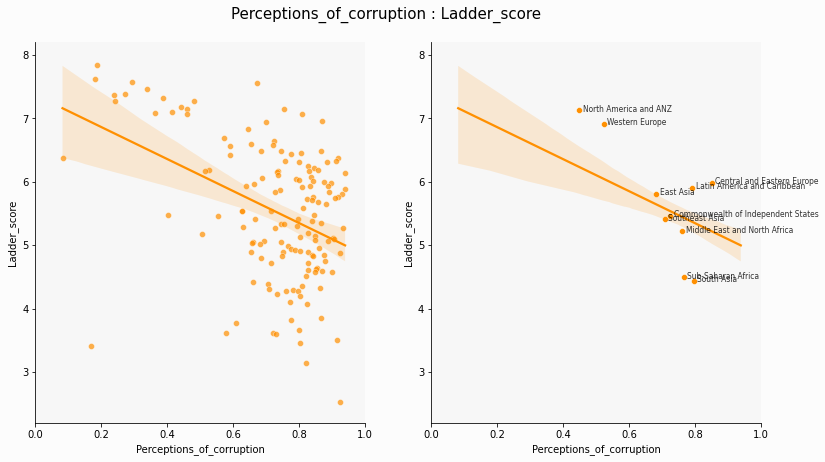

In [47]:
top_bottom_barplot(x, annot_color=['#FFFFFF', '#000000'])
pair_regplot(x, (0,1), 0.01, -0.02)

So far, it looks like there are 3 regional clusters in this data: 

- Western Europe and North America-ANZ
- Sub-Saharan Africa and South Asia
- Rest of the world

### Regions and factors

#### Western Europe and North America-ANZ

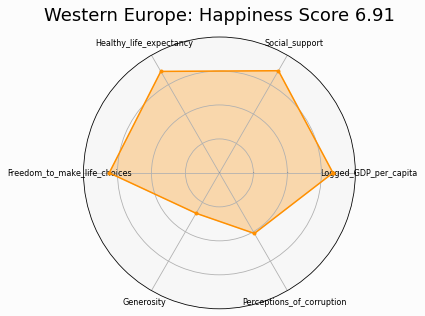

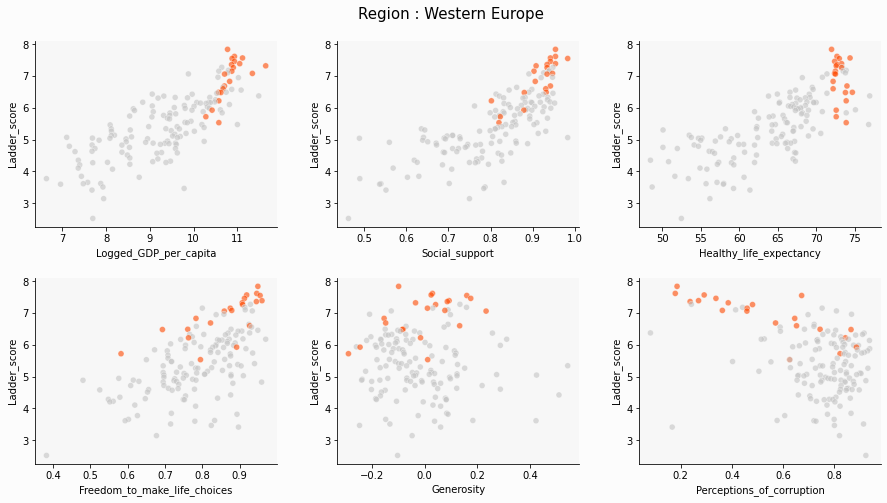

In [48]:
radar_chart('Western Europe', 'r')
contrast_scatterplot('Western Europe')

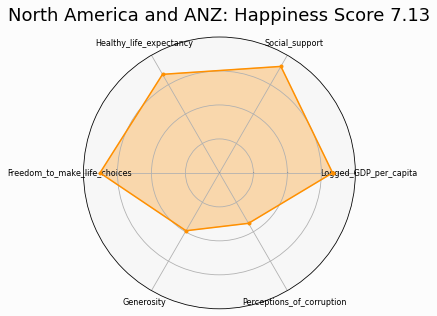

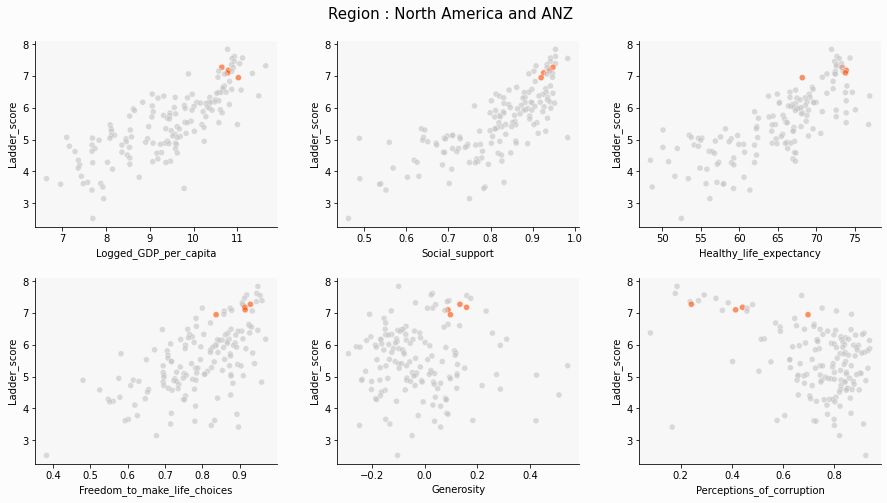

In [49]:
radar_chart('North America and ANZ', 'r')
contrast_scatterplot('North America and ANZ')

Western Europe and North America-ANZ share similar structure. They both got high level of happiness, income, social support, life expectancy and freedom. Their perception of corruption is low.

#### Sub-Saharan Africa and South Asia

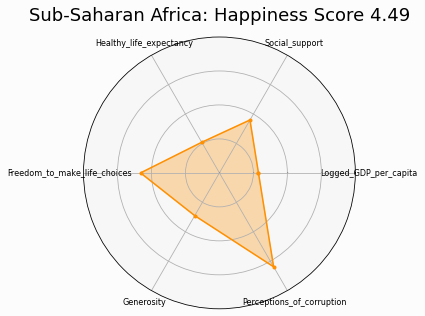

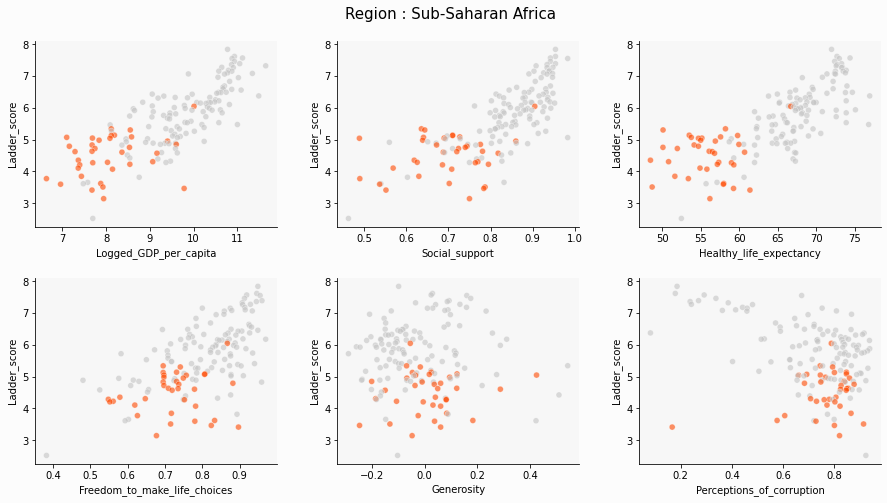

In [50]:
radar_chart('Sub-Saharan Africa', 'r')
contrast_scatterplot('Sub-Saharan Africa')

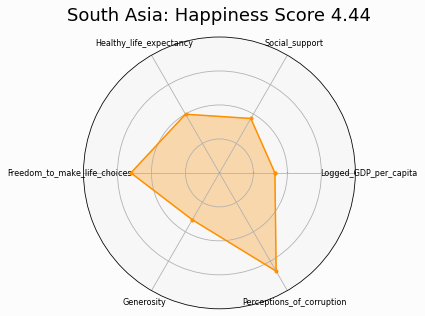

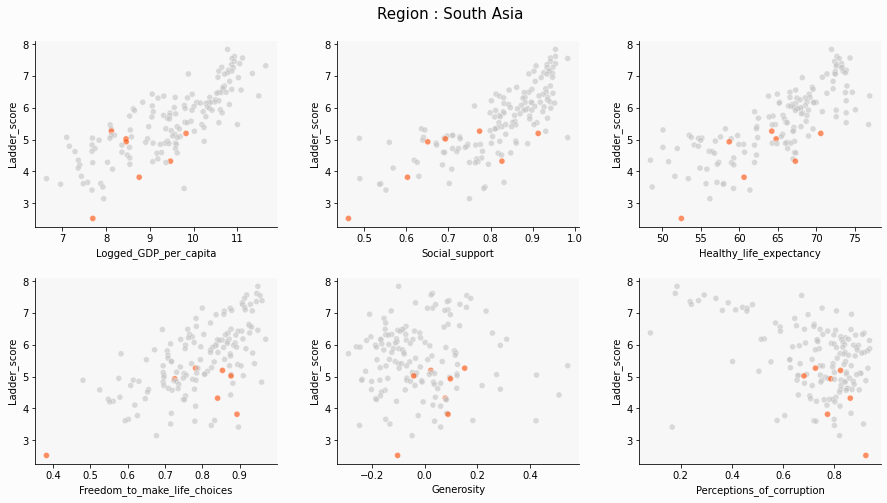

In [51]:
radar_chart('South Asia', 'r')
contrast_scatterplot('South Asia')

#### The rest of the world

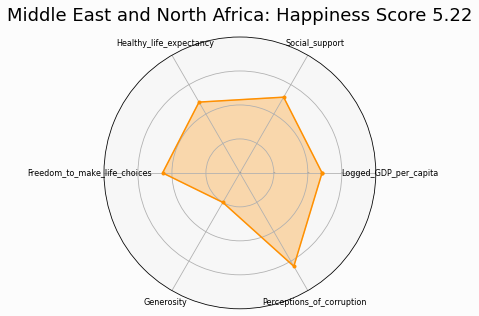

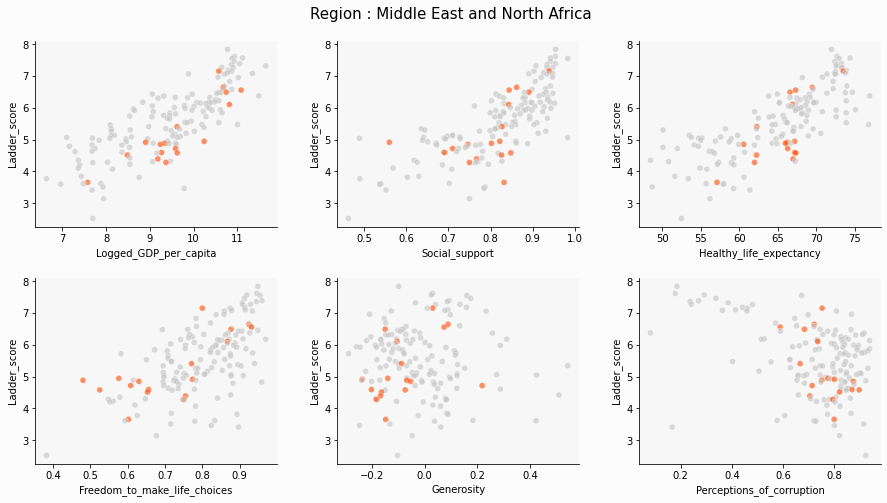

In [52]:
radar_chart('Middle East and North Africa', 'r')
contrast_scatterplot('Middle East and North Africa')

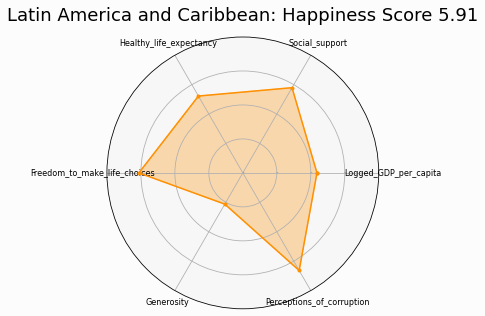

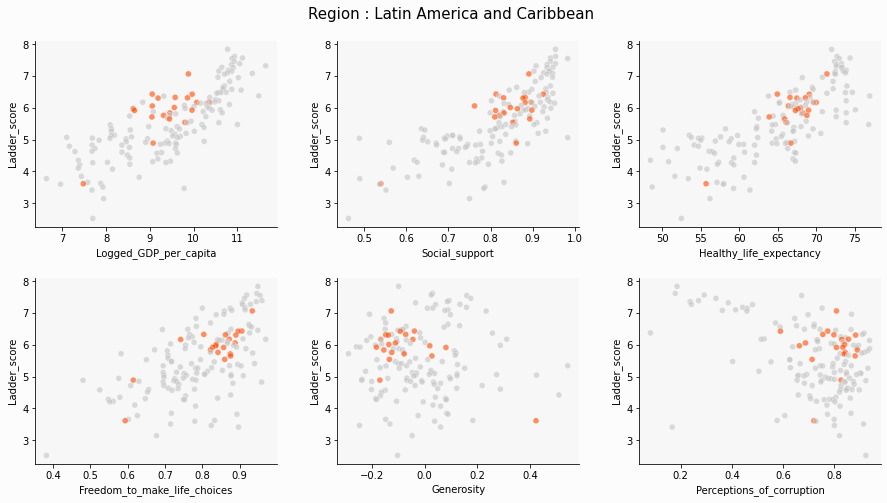

In [53]:
radar_chart('Latin America and Caribbean', 'r')
contrast_scatterplot('Latin America and Caribbean')

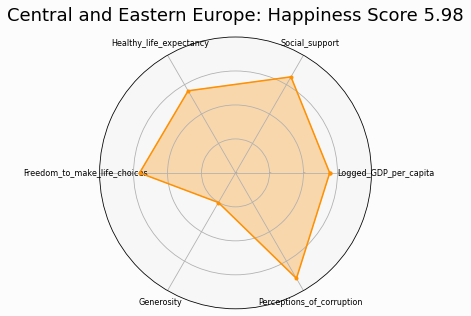

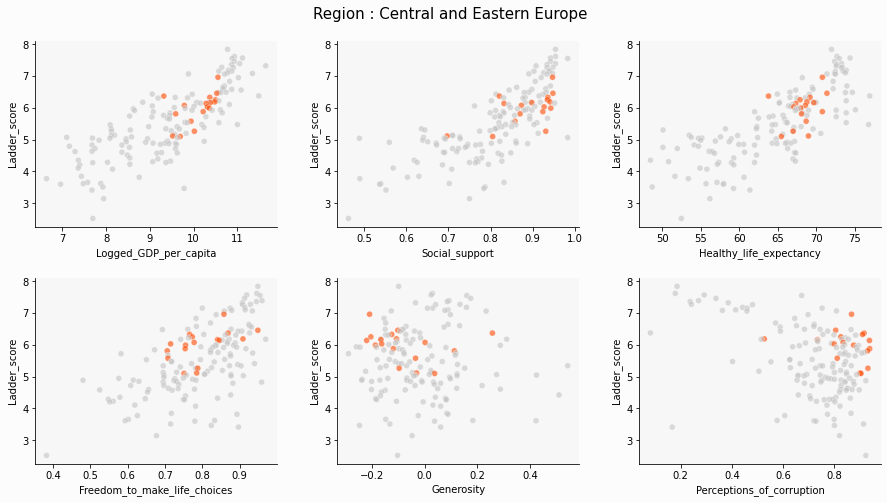

In [54]:
radar_chart('Central and Eastern Europe', 'r')
contrast_scatterplot('Central and Eastern Europe')

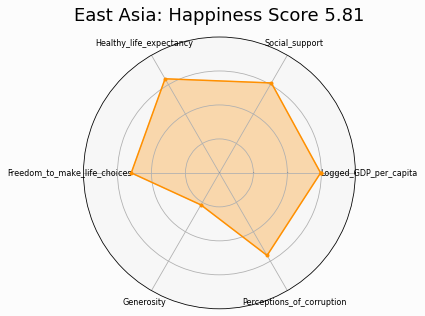

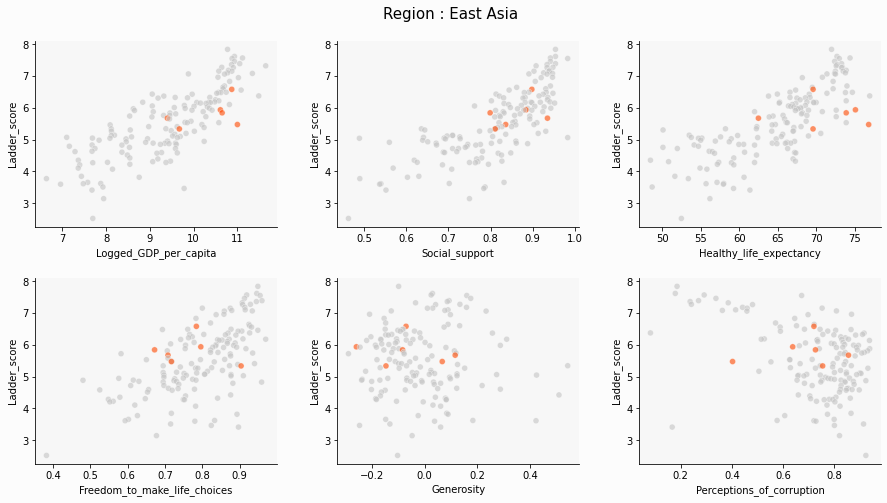

In [55]:
radar_chart('East Asia', 'r')
contrast_scatterplot('East Asia')

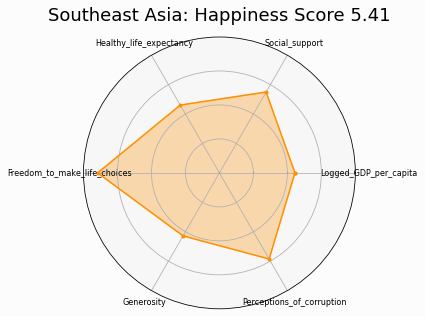

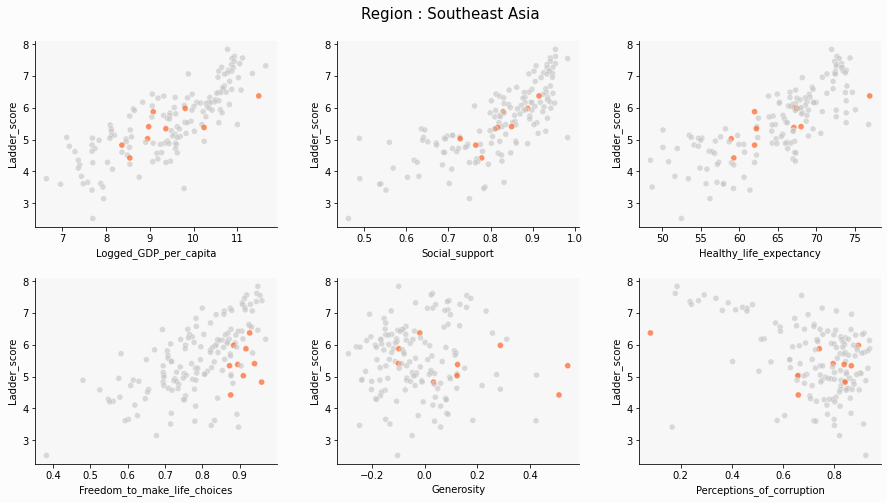

In [56]:
radar_chart('Southeast Asia', 'r')
contrast_scatterplot('Southeast Asia')

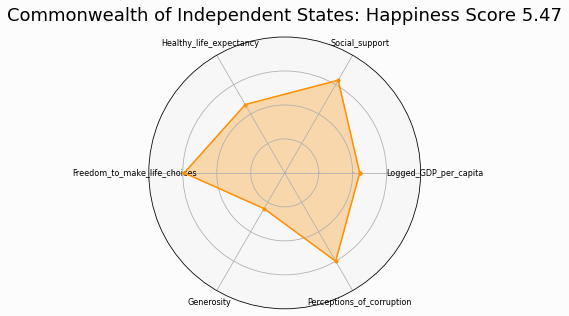

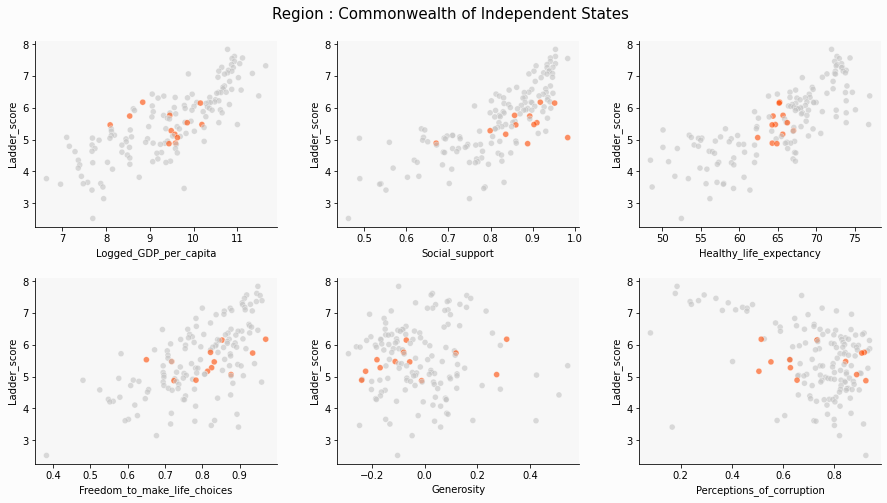

In [57]:
radar_chart('Commonwealth of Independent States', 'r')
contrast_scatterplot('Commonwealth of Independent States')

### Focus on South Korea

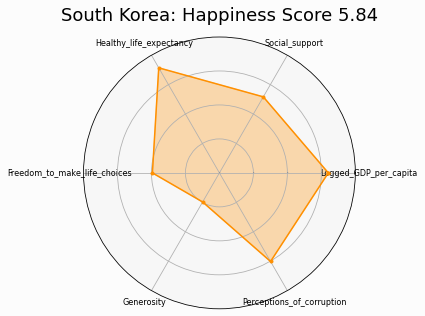

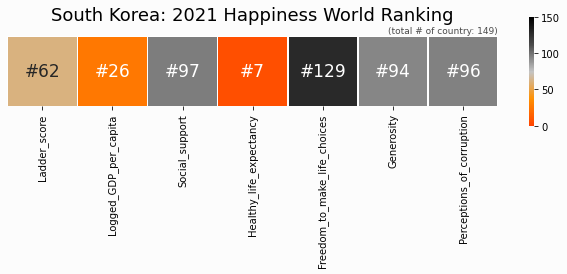

In [58]:
radar_chart('South Korea', 'c')

kor_rank = rank_data[rank_data['Country_name'] == 'South Korea'].drop('Regional_indicator', axis=1).set_index('Country_name')

fig = plt.figure(figsize=(11,2))
ax = sns.heatmap(kor_rank, vmin=0, vmax=150, cmap=heat_cmap_r, annot=True, annot_kws={'size':17},
                 fmt='g', linewidth=.5, square=True)
for t in ax.texts: 
    t.set_text('#' + t.get_text())
    
ax.set_title(f'South Korea: 2021 Happiness World Ranking', fontdict={'fontsize':18}, pad=16)
ax.text(7.0, -0.05, '(total # of country: 149)', fontsize=9, ha="right", color='#4B4B4B')
ax.yaxis.set_ticks([])
ax.set_yticklabels('')
ax.set_ylabel('');

South Korea ranked \#62 on ladder score out of 149 countries, which is litte above the median. 

South Korea has excellent scores in: 
- GDP per capita
- healthy life expectancy 

South Korea has poor scores in:
- social support
- freedom to make life choices
- generosity 
- perceptions of corruption.

#### South Korea vs Top 10 Happiest countries

I used 4 groups for this analysis:
 - South Korea
 - Average of top 10 countries (Finland, Denmark, Switzerland, Iceland, Netherlands, Norway, Sweden, Luxembourg, New Zealand and Austria)
 - Average of East Asian countries (Taiwan, Japan. South Korea, Mongolia, Hong Kong and China)
 - World Average

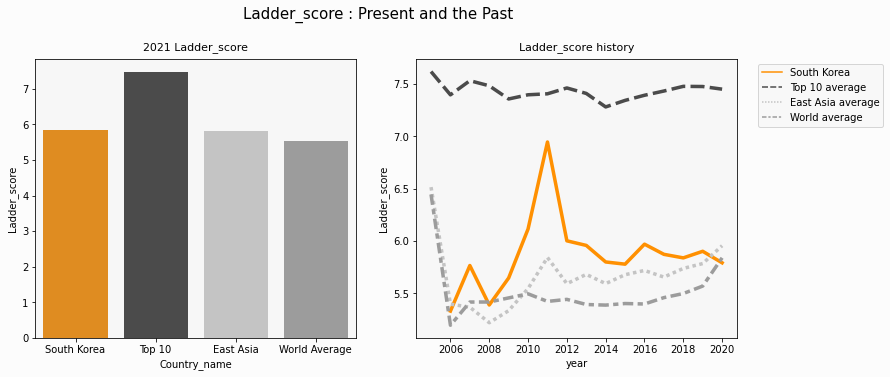

In [59]:
bar_and_line(kor_compare_data, kor_compare_ts_data, 'Ladder_score')

Score of South Korea had improved a bit, but still got long way to reach Top 10. By the way, I've been living in South Korea for my whole  life and I have no idea why happiness score of South Korea had spiked in 2011.

Let's look at the factors.

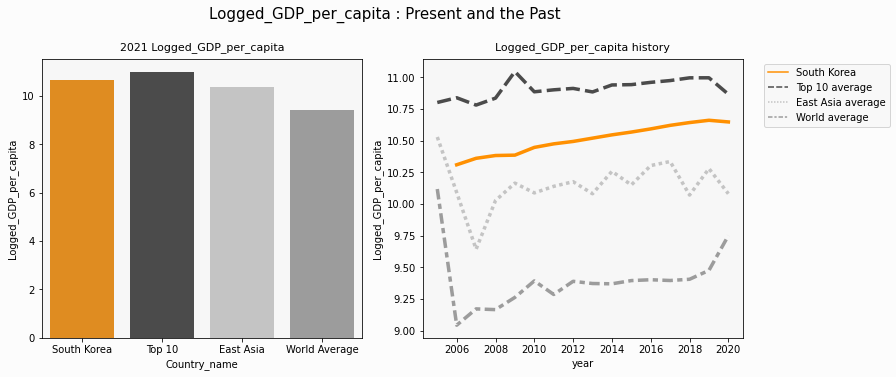

In [60]:
bar_and_line(kor_compare_data, kor_compare_ts_data, 'Logged_GDP_per_capita')

There's still a gap between South Korea and Top 10, but it's closing.

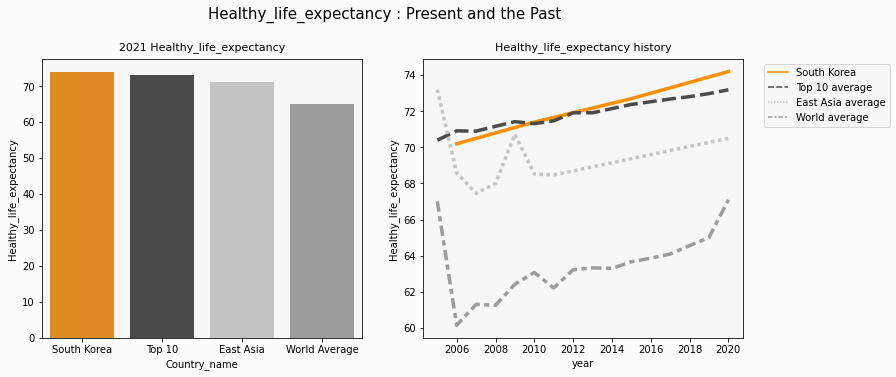

In [61]:
bar_and_line(kor_compare_data, kor_compare_ts_data, 'Healthy_life_expectancy')

South Korea ranked \#7 on healthy life expectancy in 2021. South Korea is already on the top, even better than top 10 happiest countries.

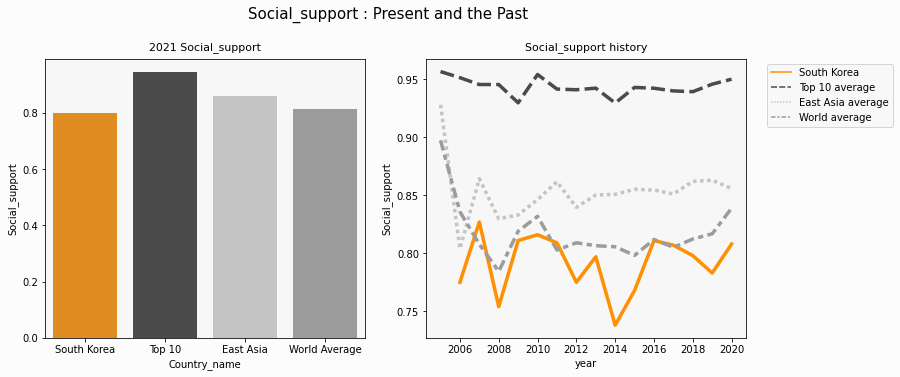

In [62]:
bar_and_line(kor_compare_data, kor_compare_ts_data, 'Social_support')

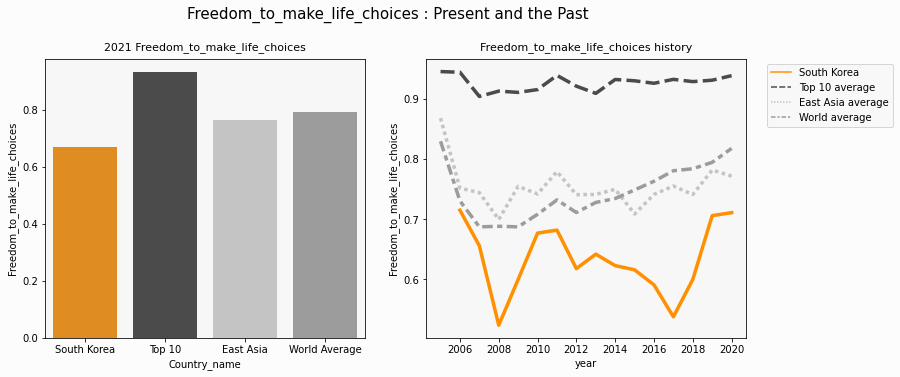

In [63]:
bar_and_line(kor_compare_data, kor_compare_ts_data, 'Freedom_to_make_life_choices')

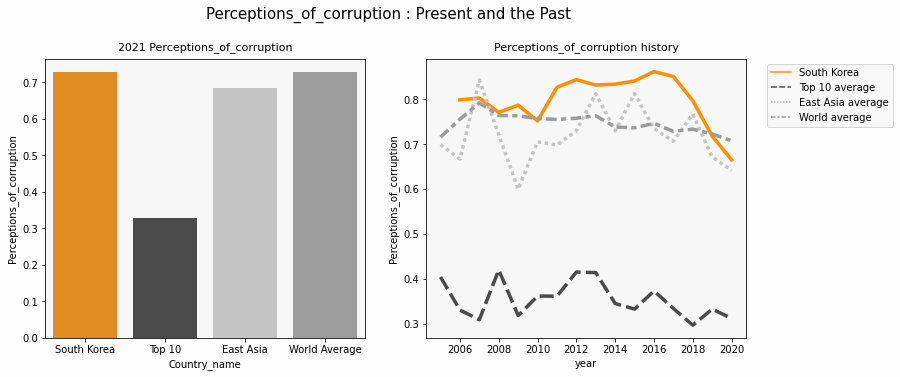

In [64]:
bar_and_line(kor_compare_data, kor_compare_ts_data, 'Perceptions_of_corruption')

In 2021, Korea ranked \#94 on social support, \#129 on freedom and \#96 on perception of corruption. This data shows that maybe South Korea is economically advanced country, but still needs more improvement on social and cultural aspects.

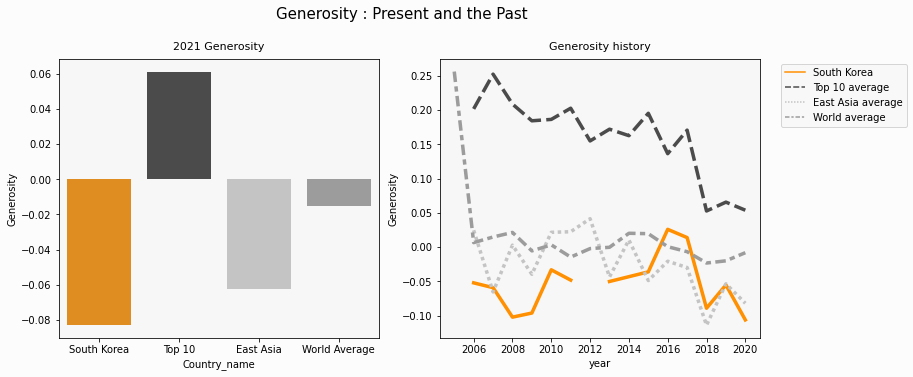

In [65]:
bar_and_line(kor_compare_data, kor_compare_ts_data, 'Generosity')

The result is quite interesting. In correlation analysis, it turned out that generosity has extremely weak correlation between happiness, but top 10 happiest countries scored way higher than other groups. But the diffence between top 10 countries and others is becoming smaller because generosity score from top 10 countries is dropping fast. I wonder what affected their generousity lately.

#### Which country is similar to South Korea?

First, I looked for countries with similar happiness score.

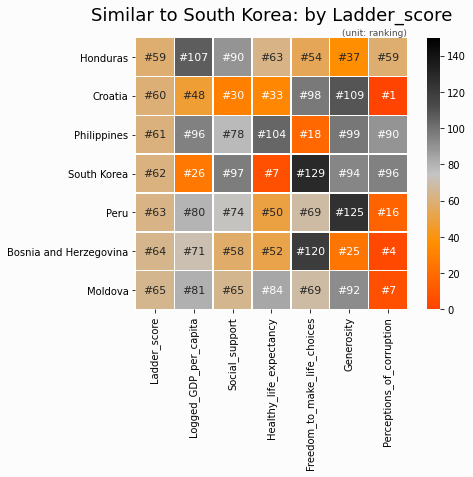

In [66]:
neighborhood_heatmap('South Korea', 'Ladder_score')

In this group, South Korea's happiness score seems relatively low compared to its economic status.

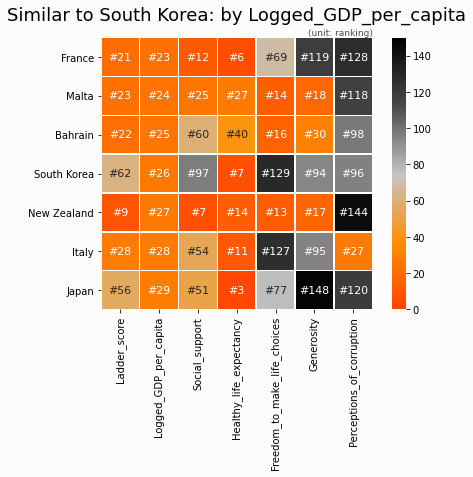

In [67]:
neighborhood_heatmap('South Korea', 'Logged_GDP_per_capita')

Two East Asian countries in this group, South Korea and Japan, had scored relatively low compared to other countries with similar income level.

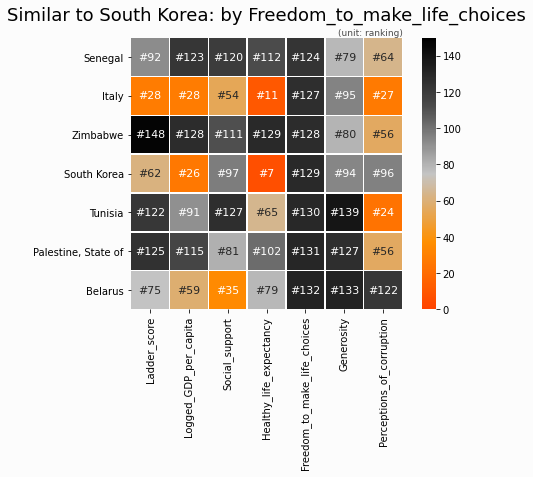

In [68]:
neighborhood_heatmap('South Korea', 'Freedom_to_make_life_choices')

South Korea and Italy have extremely poor freedom level considering their economic position.

It looks like finding similar countries based on happiness score or single factor seems pretty hard. Every factor need to be considered.

$$\text{distance}(p, q) = \sqrt{ (p_1 - q_1)^2 + (p_2 - q_2)^2 + \cdots + (p_n - q_n)^2 }$$

By applying Euclidean distance on every min-max scaled factors, I calculated the similarity between South Korea and other countries. (I also tried standard scaling, and there wasn't a big difference.)

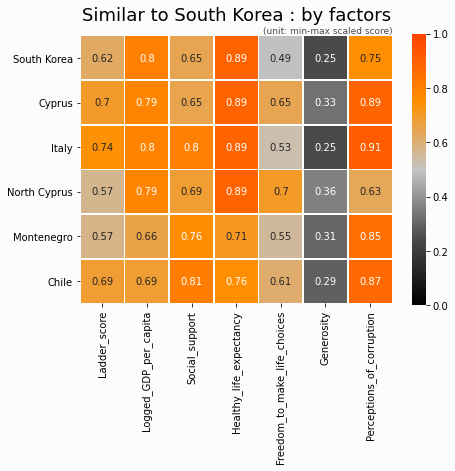

In [69]:
kor_dist_data = normed_data.copy()
kor_loc = rank_data.index[rank_data['Country_name'] == 'South Korea'][0]
kor_value = kor_dist_data.loc[kor_loc,:][factors]
kor_dist_data.loc[:, 'Distance^2'] = (kor_dist_data[factors] - kor_value).apply(lambda x: x**2).sum(axis=1)

kor_similar_5 = kor_dist_data.set_index('Country_name').sort_values('Distance^2')[:6].drop(['Regional_indicator', 'Distance^2'], axis=1)

fig = plt.figure(figsize=(7,5))
ax = sns.heatmap(kor_similar_5, vmin=0, vmax=1, cmap=heat_cmap, annot=True, fmt='.2g', linewidth=.5, square=True)
ax.text(7.0, -0.05, '(unit: min-max scaled score)', fontsize=9, ha="right", color='#4B4B4B')
ax.set_title(f'Similar to South Korea : by factors', fontdict={'fontsize':18}, pad=15)
ax.set_ylabel('');

Cyprus, Italy, North Cyprus, Montenegro and Chile are the most similar countries based on 6 given factors (ladder score was not used in similarity computation).

## Conclusion

Most people think that money determines happiness and it's not entirely wrong; income level actually showed significant correlation with happiness score. But as you can see from South Korea case, social and cultural aspect also play crucial role in our happiness.